#### 图像可视化：


##### 导包

In [1]:
import pandas as pd
import numpy as np
import math
from PIL import Image
import requests
import cv2
from glob import glob
from io import BytesIO
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display,HTML
from IPython.display import Image as IPImage
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False 
from typing import Union, Optional,List, Dict
import matplotlib.pyplot as plt



#### 图片显示方法

In [55]:


def pil2cv_img(pil_img):
    return cv2.cvtColor(np.asarray(pil_img), cv2.COLOR_RGB2BGR)

def cv2_pilimg(cv2_img):
    return Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))

def url2img(url_path='https://zihaobuck.oss-cn-hangzhou.aliyuncs.com/pict/cat1.jpg'):
    response = requests.get(url_path)
    image = Image.open(BytesIO(response.content))
    return image


def scaled_img(image, size):
    h, w, _ = image.shape
    ratio = size / max(h, w)
    resized_image = cv2.resize(image, (int(w*ratio), int(h*ratio)), cv2.INTER_AREA)
    return resized_image

def pad(image, min_height, min_width, color=(255, 255, 255)):
    
    h, w, _ = image.shape
    if h < min_height:
        h_pad_top = int((min_height - h) / 2.0)
        h_pad_bottom = min_height - h - h_pad_top
    else:
        h_pad_top = 0
        h_pad_bottom = 0
    if w < min_width:
        w_pad_left = int((min_width - w) / 2.0)
        w_pad_right = min_width - w - w_pad_left
    else:
        w_pad_left = 0
        w_pad_right = 0

    return cv2.copyMakeBorder(image, h_pad_top,
                              h_pad_bottom,
                              w_pad_left, w_pad_right,
                              cv2.BORDER_CONSTANT,
                              value=color)
    

def plot_images(images):
    
    """ 图片显示：images为PIL / RGB 图像 """

    if isinstance(images, list) and len(images) > 1:
        nrows = 1
        ncolums = len(images)
        if len(images) > 4:
            ncolums_ = math.sqrt(len(images))
            ncolums = int(ncolums_)
            nrows = int(ncolums + 1) if ncolums_ > ncolums else ncolums
        plt.figure(figsize=(12,8))
        for i, im in enumerate(images):
            plt.subplot(nrows, ncolums, i + 1)
            plt.grid(False)
            plt.imshow(im), plt.axis('off')
    else:
        plt.figure(figsize=(12,8))
        try:
            plt.imshow(images)
        except:
            plt.imshow(images[0])
        finally:
            plt.grid(False)
            plt.axis('off')


def show_local_images(imgfiles):
    
    """ 读取本地图片并显示 """
    
    if isinstance(imgfiles, list) and len(imgfiles) > 1:
        nrows = 1
        ncolums = len(imgfiles)
        if len(imgfiles) > 4:
            ncolums_ = math.sqrt(len(imgfiles))
            ncolums = int(ncolums_)
            nrows = int(ncolums + 1) if ncolums_ > ncolums else ncolums
        
        plt.figure(figsize=(12,8))
        for i, img_path in enumerate(imgfiles):
            plt.subplot(nrows, ncolums, i + 1)
            plt.grid(False)
            plt.imshow(Image.open(img_path).convert('RGB')), plt.axis('off')
    else:
        plt.figure(figsize=(12,8))
        try:
            plt.imshow(Image.open(imgfiles))
        except:
            plt.imshow(Image.open(imgfiles[0]))
        finally:
            plt.grid(False)
            plt.axis('off')



def gallery(imglist: Optional[List], ids: Optional[List]=None, tags: Optional[List]=None, default_hight: Optional[str]='300px'):
    
    """ 显示图片：imglist：url列表或图片地址列表  """

    figures = []
    if ids is None:
        ids = []
    if tags is None:
        tags = []
    
    for i, img_path in enumerate(imglist):
        mid = ids[i] if ids else ''
        tag = tags[i] if tags else ""
        file_info = f'<figcaption style="font-size: 1em;"><a target="_blank" href="{img_path}" style="display:inline;margin:1px"/> <br> {mid} </figcaption>'
        desc_img = f'<figcaption style="font-size: 1em;"><a target="_blank" href="{img_path} " style="word-break: normal;"> <b> {tag} </b> <br> 【点击查看】<br> </a></figcaption>'
       
        figures.append(
            f"""
                <figure style="margin: 5px !important;">
                    {file_info}
                    <a target="_blank"  style="word-break: normal;"><img src="{img_path}" style="height: {default_hight}"></a>
                    {desc_img}
                </figure>
            """
            )


    return display(HTML(
                    data=f"""
                        <div style="display: flex; flex-flow: row wrap; text-align: center;">
                        {''.join(figures)}
                        </div>
                        """
                ))



def show_mata_images(images, n_rows: Optional[int] = None, n_cols: Optional[int] = None, box_size: Optional[int] = None,
                     use_bg: Optional[bool] = False):
	""" 多张图像为一张大图, images: cv2_img / np.array """

	num_imgs = len(images)
	if box_size is None:
		box_size = images[0].shape[0]

	if not n_rows and not n_cols:
		n_rows_ = math.sqrt(num_imgs)
		n_rows = int(n_rows_)
		if use_bg:
			n_cols = int(n_rows_ + 1) if n_rows_ > n_rows else n_rows
		else:
			n_cols = n_rows

	elif not n_cols:
		if use_bg:
			n_cols = int(num_imgs / n_rows) + 1 if (num_imgs / n_rows) > int(num_imgs / n_rows) else int(
				num_imgs / n_rows)
		else:
			n_cols = int(num_imgs / n_rows)

	elif n_rows:
		if use_bg:
			n_rows = int(num_imgs / n_cols) + 1 if (num_imgs / n_cols) > int(num_imgs / n_cols) else int(
				num_imgs / n_cols)
		else:
			n_rows = int(num_imgs / n_cols)

	bg = np.zeros((box_size, box_size, 3), np.uint8)
	bg.fill(240)
	v_imgs = []
	for i in range(n_rows):
		h_imgs = []
		for j in range(n_cols):
			idx = i * n_cols + j
			midx = idx
			if use_bg:
				midx = idx if num_imgs > idx else -1
			cv2_img = bg if midx == -1 else images[midx]
			box_img = pad(scaled_img(cv2_img, box_size), box_size, box_size, (240,240,240))
			h_imgs.append(box_img)
		h_imgs = np.hstack(h_imgs)
		v_imgs.append(h_imgs)
	
	v_imgs = np.vstack(v_imgs)

	return cv2_pilimg(v_imgs)
            


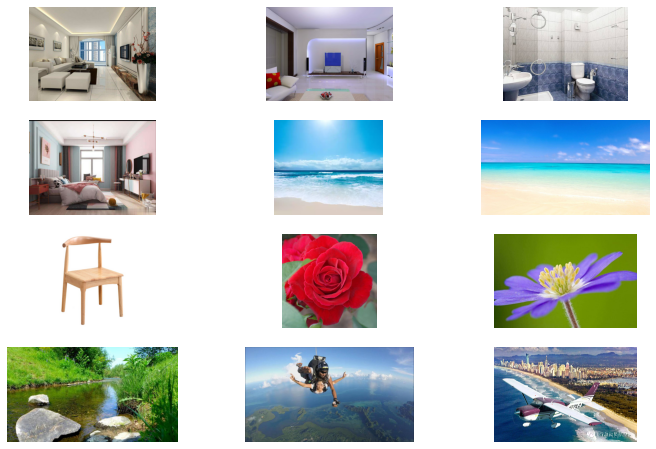

In [48]:

urls = ['https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic.16pic.com%2F00%2F16%2F64%2F16pic_1664996_b.jpg&refer=http%3A%2F%2Fpic.16pic.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661408152&t=ea842d03f1e5d6a0e85cf3f61fdf2920', 
        'https://img2.baidu.com/it/u=3663548919,3793842795&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=375',
        'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic.92to.com%2Flian%2F201511%2F21%2F74cf1a510d7b4232cb67688581b7b8fb.jpg&refer=http%3A%2F%2Fpic.92to.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661408885&t=5273b4fa1a152edef701782794d88ac9',
        'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fhaiju99.com%2Fu%2Fd5a4e48f-0af8-4f1b-b275-01539e39ae43%2Fimage%2F6376159666590758093454.jpg&refer=http%3A%2F%2Fhaiju99.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661411058&t=43ffaf5d05a0f37684cd4c6fc33a3a84',
       'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fb-ssl.duitang.com%2Fuploads%2Fitem%2F201704%2F30%2F20170430211314_tizAe.png&refer=http%3A%2F%2Fb-ssl.duitang.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661412828&t=6fe7d97e32e7a72604411e2593ee9832',
        'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fimg9.51tietu.net%2Fpic%2F2019-091305%2Fcbo4lx4vo0kcbo4lx4vo0k.jpg&refer=http%3A%2F%2Fimg9.51tietu.net&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661412828&t=9510d6397d13c2b4ab0480cd4b8c3875',
        ]


urls2 = ['https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fimgservice.suning.cn%2Fuimg1%2Fb2c%2Fimage%2FAm9OM-61On5oVgszQETGYQ.jpg&refer=http%3A%2F%2Fimgservice.suning.cn&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661414321&t=9d5ef6fb476b799253972d35c1a5e956',
        'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic1.16pic.com%2F00%2F34%2F65%2F16pic_3465993_b.jpg&refer=http%3A%2F%2Fpic1.16pic.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661414427&t=032701a8772f3554df011adcbd8febe2',
        'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic.16pic.com%2F00%2F36%2F07%2F16pic_3607516_b.jpg&refer=http%3A%2F%2Fpic.16pic.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661414427&t=18e74afe3adee3eb31cf343829d07b96',
        'https://img2.baidu.com/it/u=3321421978,1240716562&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=277',
        'https://img2.baidu.com/it/u=2033333987,3248895598&fm=253&fmt=auto&app=138&f=JPEG?w=889&h=500',
        'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fimg.mp.itc.cn%2Fupload%2F20170710%2F231800893f2542599969d034aa2b4c73_th.jpg&refer=http%3A%2F%2Fimg.mp.itc.cn&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1661414567&t=2ce92edd6afa0d5b46b8bb63606f6d3f'
        ]


# url2img(urls[0])
imgs = list(map(url2img, urls))
imgs2 = list(map(url2img, urls2))
imgs.extend(imgs2)
plot_images(imgs)

# show_local_images(imgfiles)

In [53]:
gallery(urls)

In [77]:
imgfiles = glob("./*.jpg")
gallery(imgfiles)

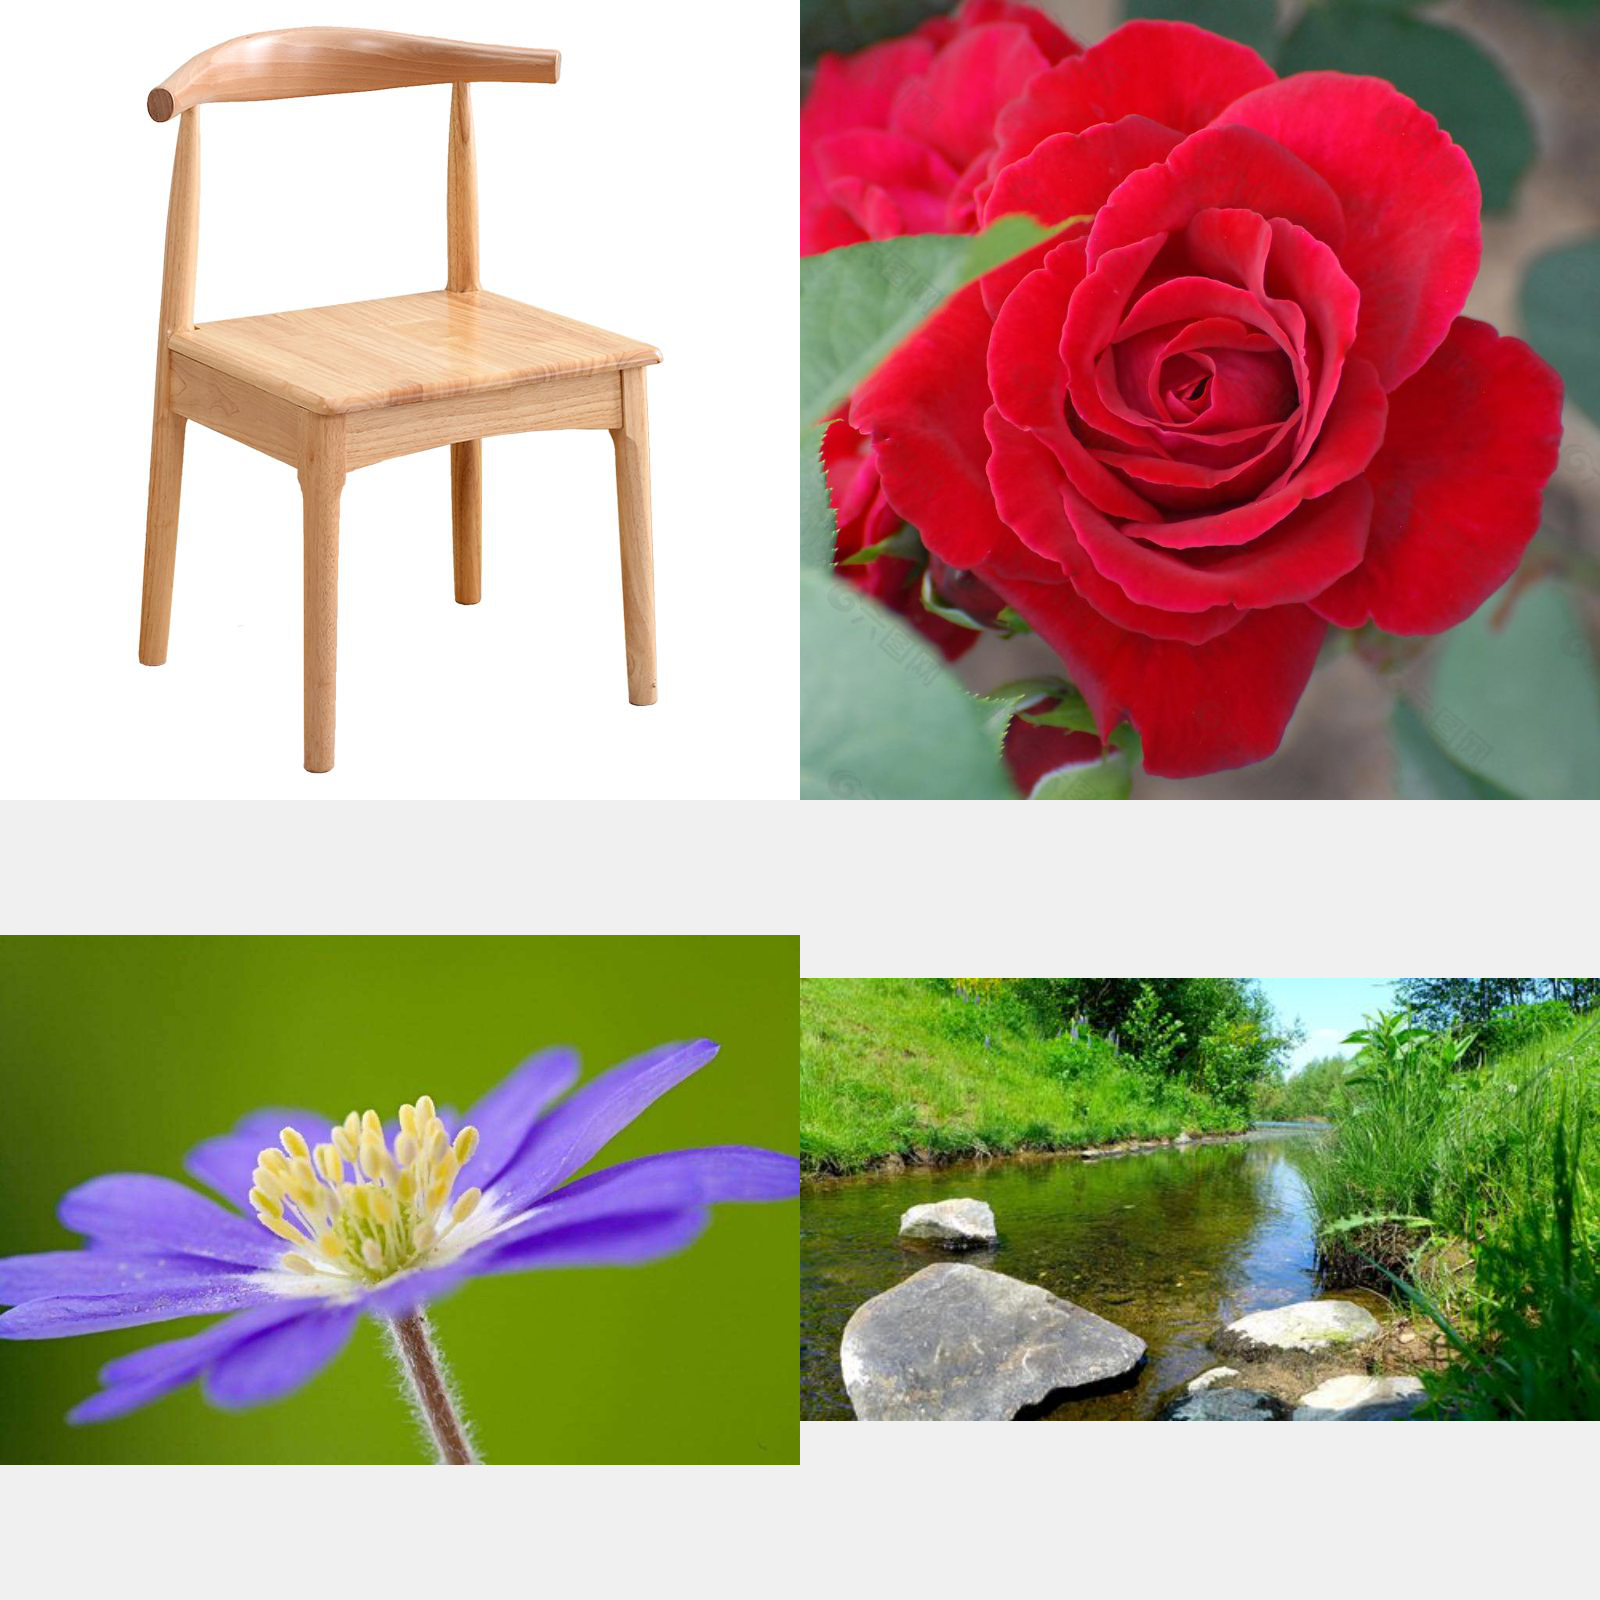

In [56]:
cv2_imgs = [pil2cv_img(x) for x in imgs2]

show_mata_images(cv2_imgs)

### 图像聚类

聚类结果：[0 1 2 3]
(100, 100, 3)


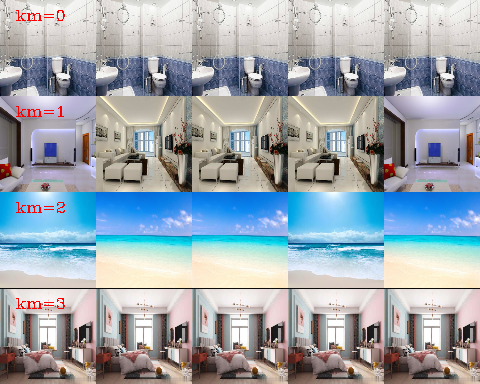

In [23]:
def images_kmeans(images: list, n_clusters:int = 2, use_bg=False):

    ### 读取图片，转化为数组
    all_images = []
    # for path in images:
    #     image = cv2.imread(path)
    #     image = cv2.resize(image, None, fx=0.5,fy=0.5)
    #     image = image.reshape(-1, )
    #     all_images.append(image)

    img_size = 300
    for img in images:
        cv2_img = pil2cv_img(img)
        cv2_img = cv2.resize(cv2_img, (img_size, img_size))
        all_images.append(cv2_img.reshape(-1,))

    ### 数组聚类
    clt = KMeans(n_clusters=n_clusters)
    clt.fit(all_images)
    labelIDs = np.unique(clt.labels_)
    print(f"聚类结果：{labelIDs}")

    ### 显示聚类结果
    km_res = []
    box_size = 96
    bg = np.zeros((100,100, 3),np.uint8)
    bg.fill(200)
    print(bg.shape)
    for labelID in labelIDs:
        # max_class = max([clt.labels_.tolist().count(x) for x in labelIDs])
        max_class = 5
        show_box = []
        idxs = np.where(clt.labels_ == labelID)[0]
        
        if use_bg:
            idxs = idxs.tolist() + [-1]*(max_class - len(idxs)) if len(idxs) < max_class else idxs ### 不允许重复， 列图像不够使使用背景图像补充
            for i in idxs:
                image = bg.copy()  if i == -1 else all_images[i].reshape(img_size, img_size, 3)
                image = cv2.resize(image, (box_size, box_size))
                show_box.append(image)
        else:
            idxs = np.random.choice(idxs, size= max_class, replace=True) ### 不够时自动补充, 方法1：
            for i in idxs:
                image = all_images[i].reshape(img_size, img_size, 3)
                image = cv2.resize(image, (box_size, box_size))
                show_box.append(image)
        
        km_label = f"km={labelID}"
        show_box = np.hstack(np.array(show_box))
        cv2.putText(show_box, km_label, (15, 20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0,0,255), 1)
        km_res.append(show_box)
    km_res = np.vstack(km_res)

    return cv2_pilimg(km_res)


images_kmeans(imgs, n_clusters=4, use_bg=False)

聚类结果：[0 1]
(100, 100, 3)


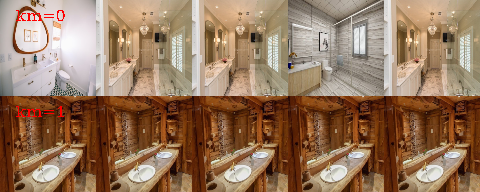

In [73]:
local_imgs = list(map(Image.open, imgfiles))
images_kmeans(local_imgs, n_clusters=2, use_bg=False)